# Urban Ecology Research Trend Analysis

Type: NLP + Time Series + Web Data | Domain: Scientific + environmental | Format: Notebook
- Use PubMed or Semantic Scholar API to extract papers on 'urban ecology'.
- Track number of publications per year.
- Perform keyword frequency and topic modeling.
- Map institutions or authors by location 
    .Use author search and Research Organization Registry (ror.org) to map institutions to locations.

In [1]:
import os
import sys
import time
import math
import pycountry
import requests
import pandas as pd
import numpy as np
import sqlite3
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import scipy.stats as stats
from itertools import combinations
from collections import Counter

BASE_URL = 'https://api.openalex.org/works'
DELAY = 1  # Small delay between requests
RETRY_DELAY = 5  # seconds before retrying on failure
YEAR_RANGE = '1970-2023' # We start on 1970 as that is considered the decade where urban ecology started gaining interest. We stop on 2023 as it's the last year with complete data
PAPERS_DB_PATH = 'papers.db'

papers_schema = """
    paperId TEXT PRIMARY KEY,
    title TEXT,
    year INTEGER,
    authors TEXT,
    url TEXT,
    search_keyword TEXT,
    firstAuthorCountryIso TEXT,
    firstAuthorId TEXT,
    journal TEXT,
    citationCount INTEGER
"""

query_list = [
    'urban ecology',
    'urban biodiversity',
    'urban ecosystem',
    'urban green spaces',
    'urban wildlife',
    'urban vegetation',
]

# Authors Data
AUTHOR_URL = 'https://api.openalex.org/authors'

authors_schema = """
    authorId TEXT PRIMARY KEY,
    name TEXT,
    last_known_institution_name TEXT,
    last_known_institution_ror TEXT,
    country_code TEXT,
    country_name TEXT
"""

ROR_CLIENT_ID = 'U7CHDW7L27GVX0ZOUVTT0Z1QG8E1BL70'

In [ ]:
# Run this to clear the .txt progress trackers

'''for keyword in query_list:
    done_file = f'done_{keyword}.txt'
    page_file = f'page_{keyword}.txt'
    cursor_file = f'cursor_{keyword}.txt'
    
    for file_path in [done_file, page_file, cursor_file]:
        if os.path.exists(file_path):
            os.remove(file_path)
            print(f'✅ Progress tracker "{file_path}" removed.')
  
if os.path.exists(PAPERS_DB_PATH):      
    os.remove(PAPERS_DB_PATH)
    print(f'✅ Output file "{PAPERS_DB_PATH}" removed.')'''

✅ Progress tracker "cursor_urban ecology.txt" removed.
✅ Progress tracker "cursor_urban biodiversity.txt" removed.
✅ Progress tracker "cursor_urban ecosystem.txt" removed.
✅ Progress tracker "cursor_urban green spaces.txt" removed.
✅ Progress tracker "cursor_urban wildlife.txt" removed.
✅ Progress tracker "cursor_urban vegetation.txt" removed.
✅ Output file "papers.db" removed.


In [2]:
# === Helper functions ===

def save_cursor(keyword, cursor):
    """Save the current cursor for pagination"""
    with open(f'cursor_{keyword}.txt', 'w') as f:
        f.write(cursor)

def load_cursor(keyword):
    """Load the last cursor for pagination"""
    filename = f'cursor_{keyword}.txt'
    if os.path.exists(filename):
        with open(filename, 'r') as f:
            return f.read().strip()
    return None

def mark_done(keyword):
    with open(f'done_{keyword}.txt', 'w') as f:
        f.write('completed')

def is_done(keyword):
    return os.path.exists(f'done_{keyword}.txt')

def delete_cursor(keyword):
    """Clean up cursor tracking file when done"""
    filename = f'cursor_{keyword}.txt'
    if os.path.exists(filename):
        os.remove(filename)

def get_first_author_country(authorships_list):
    """Extract country ISO code prioritizing first author, with fallback to other authors"""
    if not authorships_list:
        return None
    
    first_authorship = authorships_list[0]
    institutions = first_authorship.get('institutions', [])
    
    for institution in institutions:
        country_code = institution.get('country_code')
        if country_code:
            return country_code
    
    for authorship in authorships_list[1:]:
        institutions = authorship.get('institutions', [])
        
        for institution in institutions:
            country_code = institution.get('country_code')
            if country_code:
                return country_code
    
    return None

In [3]:
# === Database and Dataframe setup ===

def init_table(db_path, table_name, schema_sql):
    conn = sqlite3.connect(db_path)
    c = conn.cursor()
    c.execute(f'CREATE TABLE IF NOT EXISTS {table_name} ({schema_sql})')
    conn.commit()
    conn.close()
    
def save_paper_to_db(paper, keyword):
    conn = sqlite3.connect(PAPERS_DB_PATH)
    c = conn.cursor()

    paper_id = paper.get('id', '').replace('https://openalex.org/', '')
    title = paper.get('title')
    year = paper.get('publication_year')
    citation_count = paper.get('cited_by_count', 0)
    
    primary_location = paper.get('primary_location', {})
    journal = None
    url = None
    if primary_location:
        source = primary_location.get('source', {})
        journal = source.get('display_name') if source else None
        url = primary_location.get('landing_page_url')
    
    authorships = paper.get('authorships', [])
    authors_list = []
    first_author_id = None
    first_author_country = None
    
    for authorship in authorships:
        author = authorship.get('author', {})
        author_name = author.get('display_name')
        if author_name:
            authors_list.append(author_name)
            
        if not first_author_id and author.get('id'):
            first_author_id = author.get('id').replace('https://openalex.org/', '')
            first_author_country = get_first_author_country([authorship])
    
    authors = ', '.join(authors_list)

    try:
        c.execute('SELECT search_keyword FROM papers WHERE paperId = ?', (paper_id,))
        existing = c.fetchone()
        
        if existing:
            existing_keywords = existing[0].split(', ') if existing[0] else []
            if keyword not in existing_keywords:
                existing_keywords.append(keyword)
                updated_keywords = ', '.join(existing_keywords)
                c.execute('UPDATE papers SET search_keyword = ? WHERE paperId = ?', 
                         (updated_keywords, paper_id))
        else:
            c.execute("""
                INSERT INTO papers 
                (paperId, title, year, authors, url, search_keyword, firstAuthorCountryIso, 
                 firstAuthorId, journal, citationCount)
                VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
            """, (paper_id, title, year, authors, url, keyword, first_author_country, 
                  first_author_id, journal, citation_count))
        
        conn.commit()
    except sqlite3.Error as e:
        print(f'❌ DB error for paper {paper_id}: {e}')
    finally:
        conn.close()

In [5]:
'''# === Main loop for paper retrieval from OpenAlex ===

init_table(PAPERS_DB_PATH, 'papers', papers_schema)

for keyword in query_list:
    print(f'\n🔍 Processing keyword: "{keyword}"')

    if is_done(keyword):
        print(f'✅ Keyword "{keyword}" already completed. Skipping.')
        continue

    current_cursor = load_cursor(keyword)
    if current_cursor:
        print(f'🔄 Resuming from saved cursor for "{keyword}"')
        cursor = current_cursor
    else:
        print(f'⏳ Starting fresh for keyword "{keyword}"')
        cursor = '*'

    retrieved = 0
    page_count = 0

    while True:
        page_count += 1
        
        params = {
            'search': keyword,
            'filter': f'type:journal-article|book|book-chapter|monograph,publication_year:{YEAR_RANGE}',
            'per_page': 200,
            'cursor': cursor,
            'mailto': 'andre.borja.miranda@gmail.com'
        }

        for attempt in range(2):
            try:
                sys.stdout.flush() # Flush statements to avoid an issue that waas happening where print statements were duplicated after the request
                
                response = requests.get(BASE_URL, params=params, timeout=30)
                response.raise_for_status()
                
                sys.stdout.flush()
                
                data = response.json()
                break
            except requests.exceptions.RequestException as e:
                print(f'❌ Request error on attempt {attempt+1} for "{keyword}" page {page_count}: {e}')
                if attempt == 0:
                    print(f'⏳ Retrying after {RETRY_DELAY} seconds...')
                    time.sleep(RETRY_DELAY)
                else:
                    print('⚠️ Skipping this batch due to repeated failure.')
                    data = None

        if data is None:
            print(f'⚠️ No data retrieved for keyword "{keyword}" page {page_count}, breaking loop.')
            break

        if 'error' in data:
            print(f'❌ API Error for "{keyword}": {data.get("message", "Unknown error")}')
            break

        papers = data.get('results', [])
        if not papers:
            print(f'✅ No more papers available for "{keyword}" (reached end of results)')
            print(f'✅ Completed all available results for "{keyword}" (total: {retrieved} papers across {page_count} pages)')
            delete_cursor(keyword)
            mark_done(keyword)
            break

        retrieved += len(papers)
        print(f'📄 Page {page_count}: {retrieved} papers retrieved for "{keyword}"')

        for paper in papers:
            save_paper_to_db(paper, keyword)

        meta = data.get('meta', {})
        next_cursor = meta.get('next_cursor')
        
        if next_cursor:
            cursor = next_cursor
            save_cursor(keyword, cursor)
            time.sleep(DELAY)
            
        else:
            #Fallback redundancy in case the "if not papers" check fails
            print(f'✅ No more cursor available for "{keyword}" (total: {retrieved} papers across {page_count} pages)')
            delete_cursor(keyword)
            mark_done(keyword)
            break

print('\n🎉 All keywords processed.')'''

'# === Main loop for paper retrieval from OpenAlex ===\n\ninit_table(PAPERS_DB_PATH, \'papers\', papers_schema)\n\nfor keyword in query_list:\n    print(f\'\n🔍 Processing keyword: "{keyword}"\')\n\n    if is_done(keyword):\n        print(f\'✅ Keyword "{keyword}" already completed. Skipping.\')\n        continue\n\n    current_cursor = load_cursor(keyword)\n    if current_cursor:\n        print(f\'🔄 Resuming from saved cursor for "{keyword}"\')\n        cursor = current_cursor\n    else:\n        print(f\'⏳ Starting fresh for keyword "{keyword}"\')\n        cursor = \'*\'\n\n    retrieved = 0\n    page_count = 0\n\n    while True:\n        page_count += 1\n\n        params = {\n            \'search\': keyword,\n            \'filter\': f\'type:journal-article|book|book-chapter|monograph,publication_year:{YEAR_RANGE}\',\n            \'per_page\': 200,\n            \'cursor\': cursor,\n            \'mailto\': \'andre.borja.miranda@gmail.com\'\n        }\n\n        for attempt in range(2):\

In [5]:
with sqlite3.connect(PAPERS_DB_PATH) as conn:
    df_raw = pd.read_sql_query("""
    SELECT year, search_keyword
    FROM papers
    WHERE search_keyword IS NOT NULL AND search_keyword != ''
    """, conn)

rows = []
for _, row in df_raw.iterrows():
    keywords = [k.strip() for k in row['search_keyword'].split(',')]
    for keyword in keywords:
        if keyword:
            rows.append({'year': row['year'], 'search_keyword': keyword})

df_expanded = pd.DataFrame(rows)
df_keywords = df_expanded.groupby(['year', 'search_keyword']).size().reset_index(name='paper_count')

df_totals = df_expanded.groupby('year').size().reset_index(name='paper_count')
df_totals['search_keyword'] = 'total'

df_keywords = df_keywords.sort_values('year')
df_keywords.head()

,year,search_keyword,paper_count
0,1970,urban biodiversity,1
1,1970,urban ecology,7
2,1970,urban ecosystem,1
3,1970,urban green spaces,10
4,1970,urban vegetation,14


In [6]:
color_map = {
    'urban ecology': '#6B9BD2',
    'urban biodiversity': '#E6A366',
    'urban green spaces': '#7FB069',
    'urban wildlife': '#D67B7B',
    'urban vegetation': '#B19CD9',
    'urban ecosystem': '#E6A8D0',
    'total': '#FFD700'
}

fig = px.line(
    df_keywords,
    x='year',
    y='paper_count',
    color='search_keyword',
    color_discrete_map=color_map,
    title='Research Papers Published by Year',
    markers=True,
)

fig.update_layout(
    xaxis_title='Year',
    yaxis_title='Number of Papers',
    legend_title='Keyword',
    font=dict(size=12),
    width=1000,
    height=600,
    template='plotly_dark',
    xaxis=dict(showgrid=True,
               dtick=5,
               tickangle=45),
    yaxis=dict(showgrid=True),
)

fig.show()


Totals graph:

In [7]:
fig = px.line(
    df_totals,
    x='year',
    y='paper_count',
    color='search_keyword',
    color_discrete_map=color_map,
    title='Research Papers Published by Year',
    markers=True,
)

fig.update_layout(
    xaxis_title='Year',
    yaxis_title='Number of Papers',
    legend_title='Keyword',
    font=dict(size=12),
    width=1000,
    height=600,
    template='plotly_dark',
    xaxis=dict(showgrid=True,
               dtick=5,
               tickangle=45),
    yaxis=dict(showgrid=True),
)

fig.show()

# Regression Analysis on All Papers Published

We'll perform both linear and exponential regression analysis to determine which model better fits the overall growth pattern of urban ecology research publications. This analysis will help us understand whether the field is experiencing linear or exponential growth. 

COMPREHENSIVE GROWTH ANALYSIS - TOTAL PAPERS

MODEL COMPARISON RESULTS:
------------------------------------------------------------
Linear R²: 0.6440
Exponential R²: 0.9605
Better fit: Exponential
R² difference: +0.3165

LINEAR MODEL RESULTS:
----------------------------------------
Growth rate: 169.32 papers/year
R²: 0.6440
P-value: 2.96e-13

EXPONENTIAL MODEL RESULTS:
----------------------------------------
Annual growth rate: 11.1% per year
Doubling time: 6.6 years
R²: 0.9605
P-value: 3.70e-38


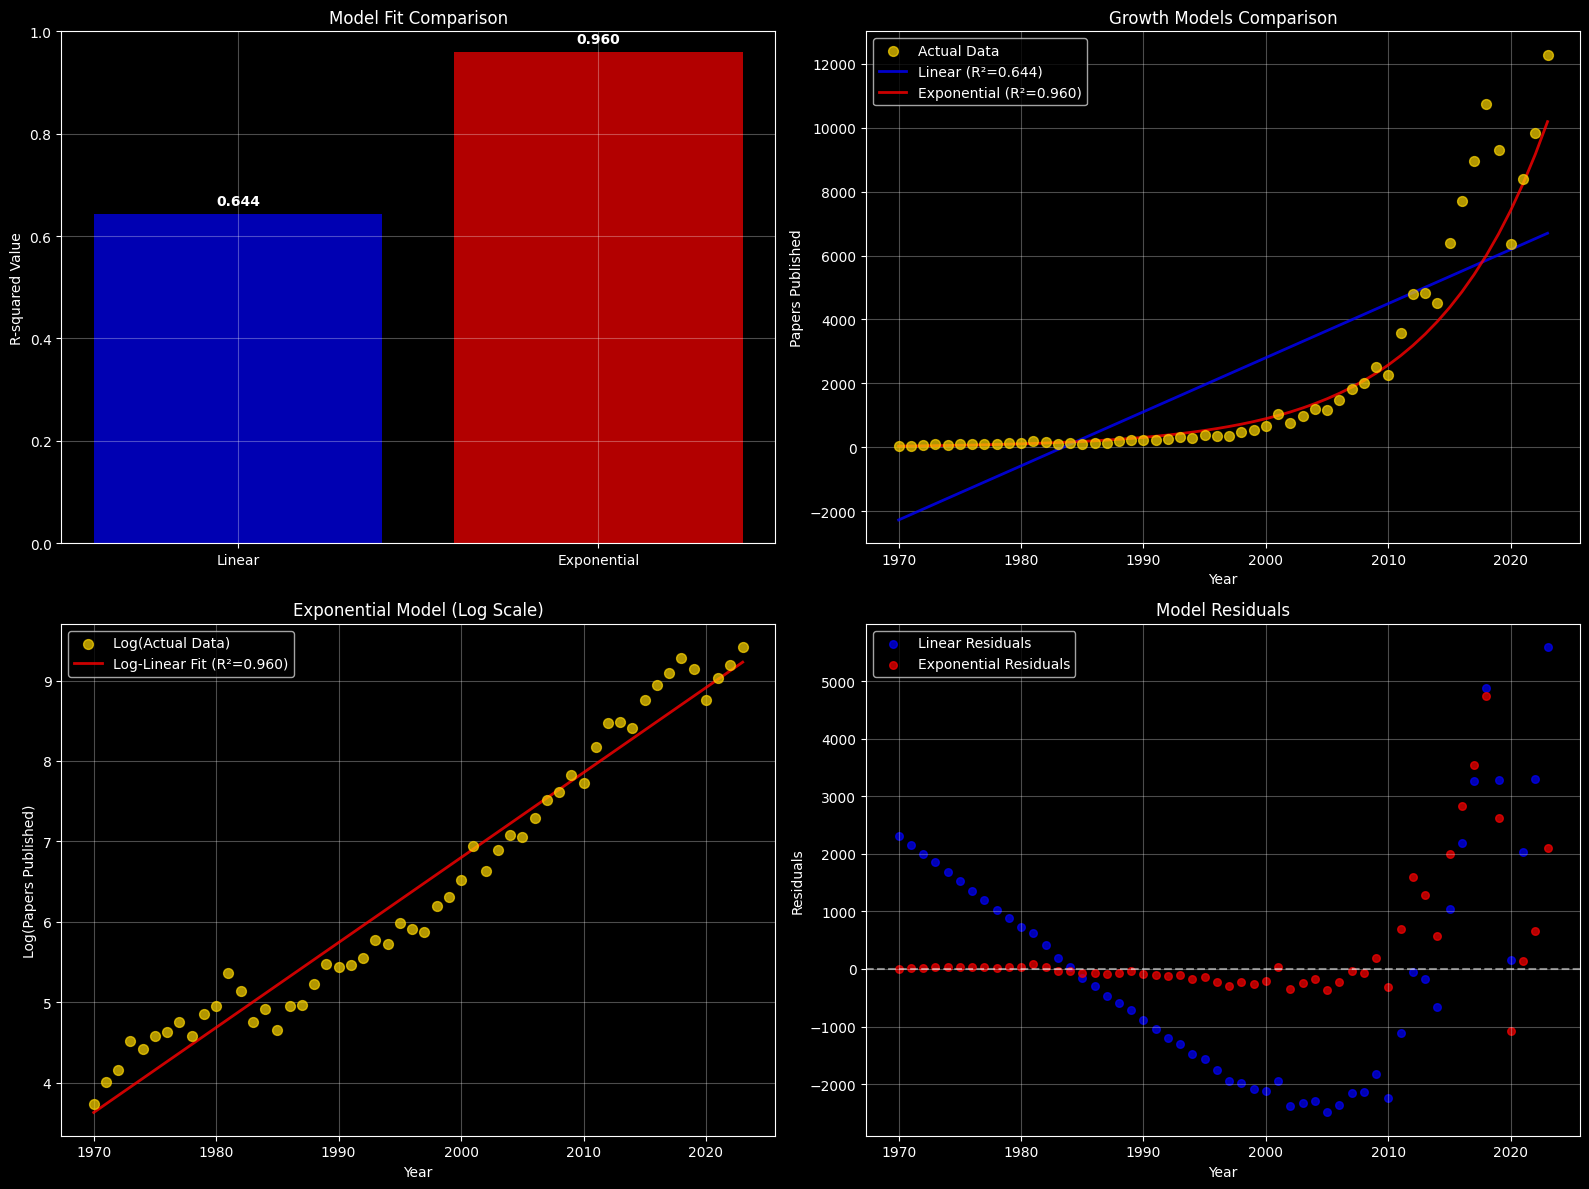


KEY INSIGHTS - TOTAL PAPERS GROWTH ANALYSIS:
✓ The field shows EXPONENTIAL growth with 11.1% annual growth rate
✓ Research output doubles every 6.6 years
✓ Exponential model explains 96.0% of variance
✓ Model improvement: +0.3165 R² difference
✓ Growth trend is statistically significant (p < 0.05)
⚠ High growth rate (11.1%/year) may not be sustainable long-term


In [9]:
def analyze_total_papers_growth():
    """
    Comprehensive analysis comparing linear vs exponential growth models for total papers
    """
    # Prepare data
    years = df_totals['year'].values
    counts = df_totals['paper_count'].values
    
    # Linear regression
    slope_linear, intercept_linear, r_value_linear, p_value_linear, std_err_linear = stats.linregress(years, counts)
    r_squared_linear = r_value_linear**2
    
    # Exponential regression (log transform)
    log_counts = np.log(counts + 1)
    slope_log, intercept_log, r_value_log, p_value_log, std_err_log = stats.linregress(years, log_counts)
    r_squared_log = r_value_log**2
    
    # Calculate growth metrics
    annual_growth_rate = (np.exp(slope_log) - 1) * 100
    doubling_time = np.log(2) / slope_log if slope_log > 0 else np.inf
    
    # Determine better fit
    better_fit = 'Exponential' if r_squared_log > r_squared_linear else 'Linear'
    r_squared_difference = r_squared_log - r_squared_linear
    
    # Generate predictions
    predicted_linear = slope_linear * years + intercept_linear
    predicted_log = np.exp(slope_log * years + intercept_log) - 1
    
    results = {
        'linear': {
            'slope': slope_linear,
            'intercept': intercept_linear,
            'r_squared': r_squared_linear,
            'p_value': p_value_linear,
            'predicted': predicted_linear
        },
        'exponential': {
            'slope': slope_log,
            'intercept': intercept_log,
            'r_squared': r_squared_log,
            'p_value': p_value_log,
            'annual_growth_rate': annual_growth_rate,
            'doubling_time': doubling_time,
            'predicted': predicted_log
        },
        'comparison': {
            'better_fit': better_fit,
            'r_squared_difference': r_squared_difference
        },
        'data': {
            'years': years,
            'counts': counts,
            'log_counts': log_counts
        }
    }
    
    return results

# Perform analysis
print('COMPREHENSIVE GROWTH ANALYSIS - TOTAL PAPERS')
print('=' * 80)

analysis = analyze_total_papers_growth()

# Display results
print('\nMODEL COMPARISON RESULTS:')
print('-' * 60)
print(f"Linear R²: {analysis['linear']['r_squared']:.4f}")
print(f"Exponential R²: {analysis['exponential']['r_squared']:.4f}")
print(f"Better fit: {analysis['comparison']['better_fit']}")
print(f"R² difference: {analysis['comparison']['r_squared_difference']:+.4f}")

print('\nLINEAR MODEL RESULTS:')
print('-' * 40)
print(f"Growth rate: {analysis['linear']['slope']:.2f} papers/year")
print(f"R²: {analysis['linear']['r_squared']:.4f}")
print(f"P-value: {analysis['linear']['p_value']:.2e}")

print('\nEXPONENTIAL MODEL RESULTS:')
print('-' * 40)
print(f"Annual growth rate: {analysis['exponential']['annual_growth_rate']:.1f}% per year")
print(f"Doubling time: {analysis['exponential']['doubling_time']:.1f} years")
print(f"R²: {analysis['exponential']['r_squared']:.4f}")
print(f"P-value: {analysis['exponential']['p_value']:.2e}")

# Create comprehensive visualization
plt.style.use('dark_background')
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Model comparison
ax1 = axes[0, 0]
models = ['Linear', 'Exponential']
r_squared_values = [analysis['linear']['r_squared'], analysis['exponential']['r_squared']]
colors = ['blue', 'red']

bars = ax1.bar(models, r_squared_values, color=colors, alpha=0.7)
ax1.set_ylabel('R-squared Value')
ax1.set_title('Model Fit Comparison')
ax1.set_ylim(0, 1)
ax1.grid(True, alpha=0.3)

for bar, value in zip(bars, r_squared_values):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

# 2. Original data with both fits
ax2 = axes[0, 1]
ax2.scatter(analysis['data']['years'], analysis['data']['counts'], 
           alpha=0.7, s=50, color='#FFD700', label='Actual Data', zorder=3)
ax2.plot(analysis['data']['years'], analysis['linear']['predicted'], 
         color='blue', linewidth=2, label=f'Linear (R²={analysis["linear"]["r_squared"]:.3f})', alpha=0.8)
ax2.plot(analysis['data']['years'], analysis['exponential']['predicted'], 
         color='red', linewidth=2, label=f'Exponential (R²={analysis["exponential"]["r_squared"]:.3f})', alpha=0.8)

ax2.set_xlabel('Year')
ax2.set_ylabel('Papers Published')
ax2.set_title('Growth Models Comparison')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Log-scale visualization
ax3 = axes[1, 0]
ax3.scatter(analysis['data']['years'], analysis['data']['log_counts'], 
           alpha=0.7, s=50, color='#FFD700', label='Log(Actual Data)', zorder=3)
ax3.plot(analysis['data']['years'], 
         analysis['exponential']['slope'] * analysis['data']['years'] + analysis['exponential']['intercept'],
         color='red', linewidth=2, label=f'Log-Linear Fit (R²={analysis["exponential"]["r_squared"]:.3f})', alpha=0.8)

ax3.set_xlabel('Year')
ax3.set_ylabel('Log(Papers Published)')
ax3.set_title('Exponential Model (Log Scale)')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Residuals analysis
ax4 = axes[1, 1]
residuals_linear = analysis['data']['counts'] - analysis['linear']['predicted']
residuals_exp = analysis['data']['counts'] - analysis['exponential']['predicted']

ax4.scatter(analysis['data']['years'], residuals_linear, 
           alpha=0.7, s=30, color='blue', label='Linear Residuals')
ax4.scatter(analysis['data']['years'], residuals_exp, 
           alpha=0.7, s=30, color='red', label='Exponential Residuals')
ax4.axhline(y=0, color='white', linestyle='--', alpha=0.5)

ax4.set_xlabel('Year')
ax4.set_ylabel('Residuals')
ax4.set_title('Model Residuals')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Key insights
print("\n" + "="*80)
print("KEY INSIGHTS - TOTAL PAPERS GROWTH ANALYSIS:")
print("="*80)

if analysis['comparison']['better_fit'] == 'Exponential':
    print(f"✓ The field shows EXPONENTIAL growth with {analysis['exponential']['annual_growth_rate']:.1f}% annual growth rate")
    print(f"✓ Research output doubles every {analysis['exponential']['doubling_time']:.1f} years")
    print(f"✓ Exponential model explains {analysis['exponential']['r_squared']*100:.1f}% of variance")
else:
    print(f"✓ The field shows LINEAR growth with {analysis['linear']['slope']:.2f} papers/year increase")
    print(f"✓ Linear model explains {analysis['linear']['r_squared']*100:.1f}% of variance")

print(f"✓ Model improvement: {analysis['comparison']['r_squared_difference']:+.4f} R² difference")

if analysis['exponential']['p_value'] < 0.05:
    print("✓ Growth trend is statistically significant (p < 0.05)")
else:
    print("⚠ Growth trend is not statistically significant (p ≥ 0.05)")

if analysis['exponential']['annual_growth_rate'] > 10:
    print(f"⚠ High growth rate ({analysis['exponential']['annual_growth_rate']:.1f}%/year) may not be sustainable long-term")
else:
    print(f"✓ Moderate growth rate ({analysis['exponential']['annual_growth_rate']:.1f}%/year) appears sustainable")

# Per Keyword Analysis

We'll do the same as above, but this time doing both the linear and exponential analysis in one go and see how both models compare on a per keyword basis.

COMPREHENSIVE GROWTH ANALYSIS

MODEL COMPARISON RESULTS:
------------------------------------------------------------
              keyword  r_squared_linear  r_squared_log   better_fit  \
2     urban ecosystem          0.615529       0.952564  Exponential   
3  urban green spaces          0.615049       0.946375  Exponential   
1       urban ecology          0.646892       0.947195  Exponential   
0  urban biodiversity          0.674296       0.939802  Exponential   
4    urban vegetation          0.693672       0.946765  Exponential   
5      urban wildlife          0.719227       0.961730  Exponential   

   annual_growth_rate_percent  r_squared_difference  
2                   12.294559              0.337035  
3                   12.061090              0.331326  
1                   10.617228              0.300303  
0                   17.977592              0.265506  
4                    8.853252              0.253093  
5                    8.589296              0.242503  


LOGA

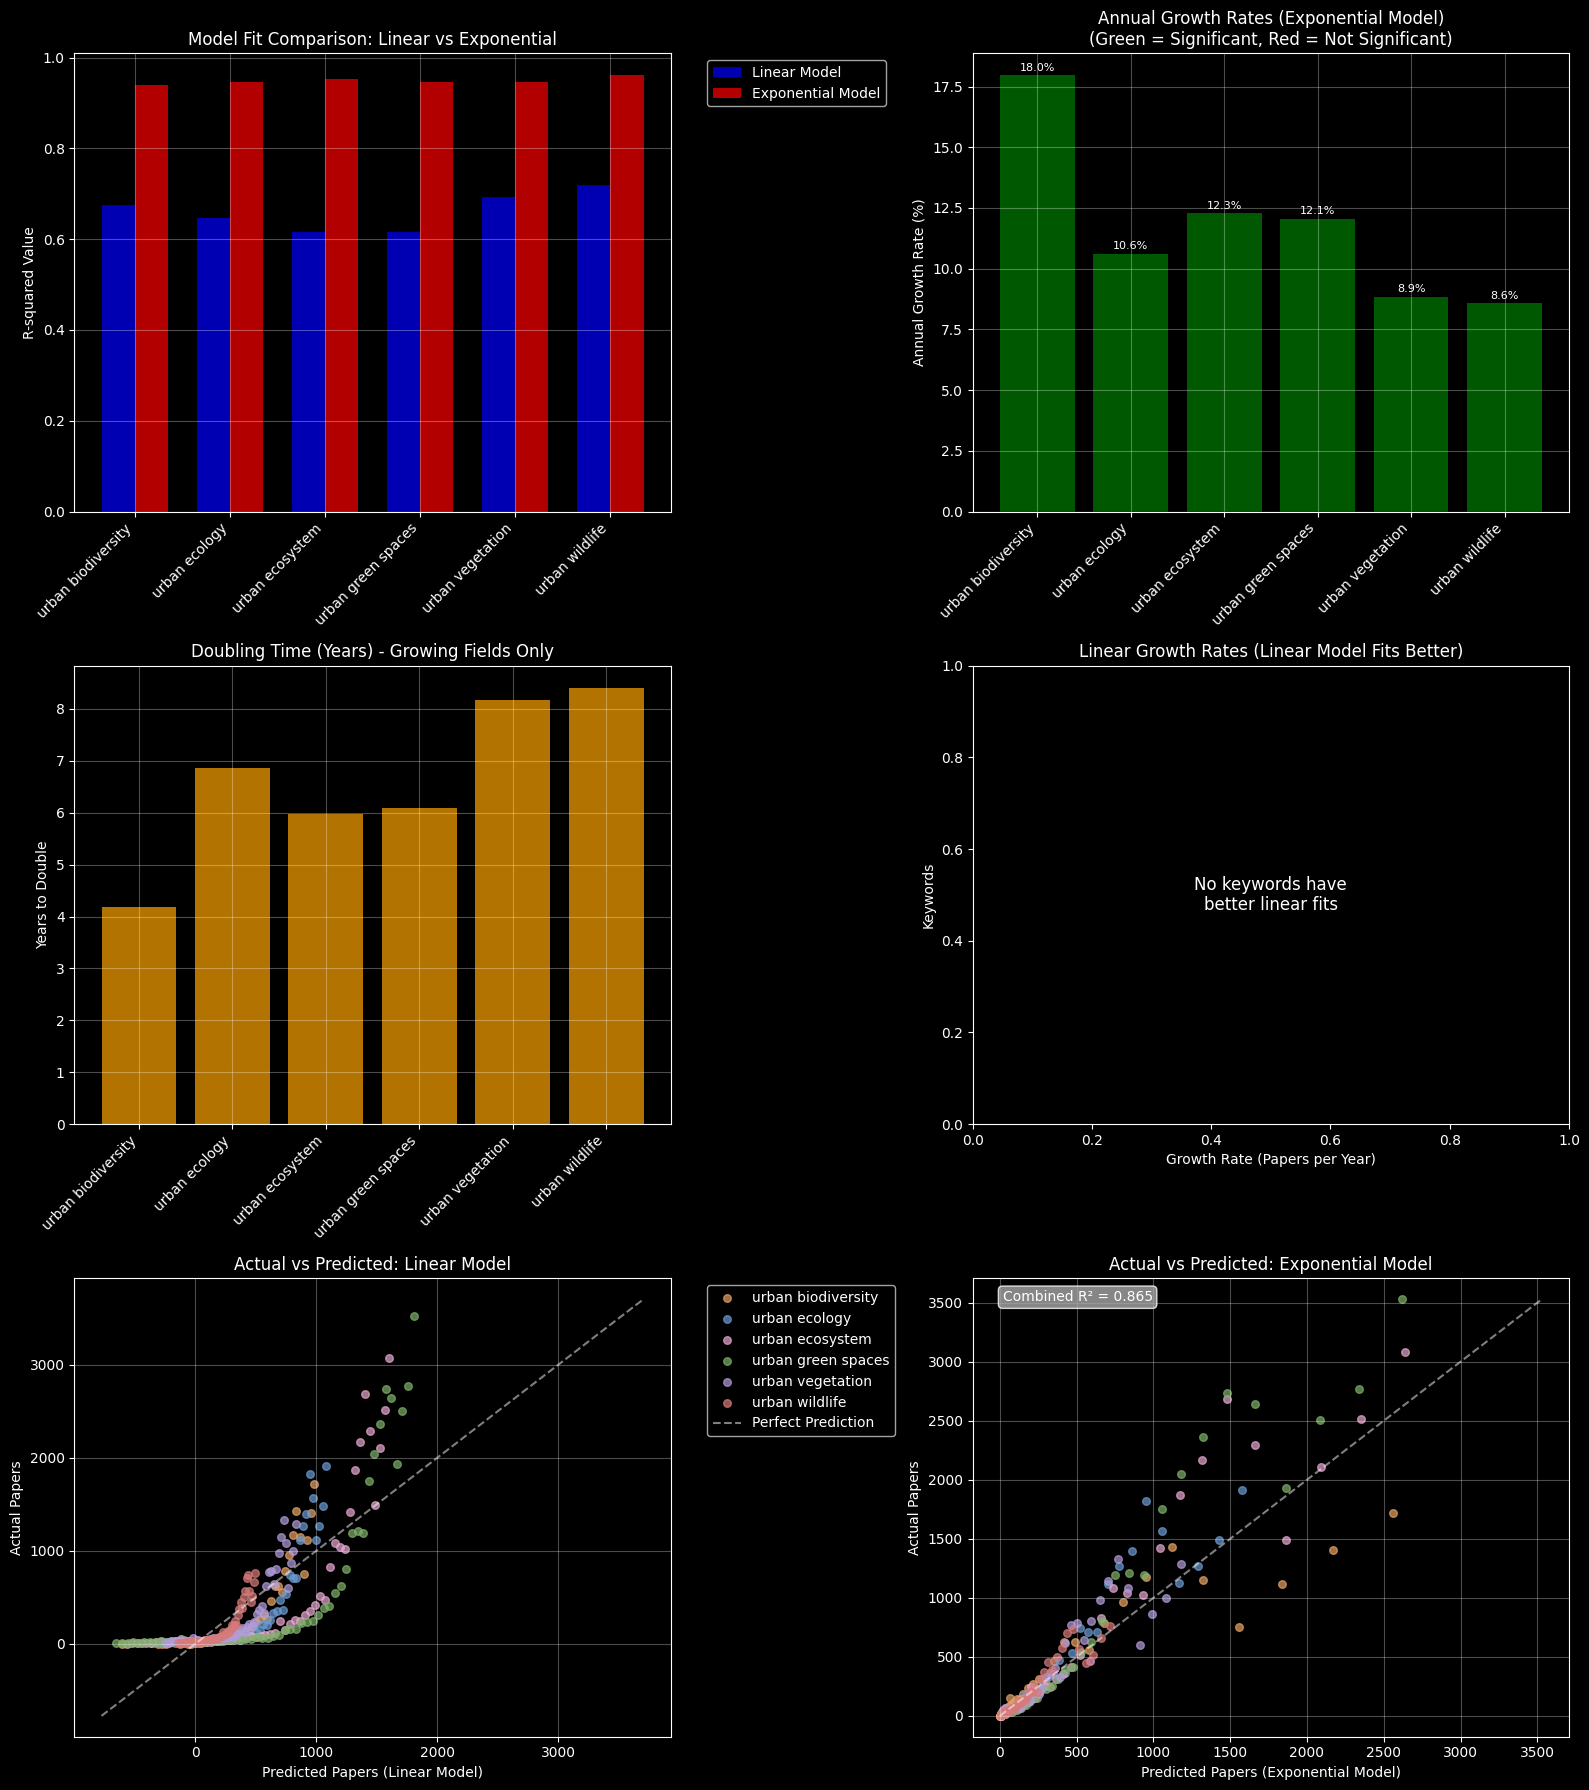


KEY INSIGHTS - GROWTH PATTERN ANALYSIS:
Fastest linear growth: urban green spaces (46.35 papers/year)
Fastest exponential growth: urban biodiversity (18.0% per year)
  - Doubling time: 4.2 years
Fields better explained by exponential growth: 6/6 (100.0%)
Significant linear trends: 6/6
Significant exponential trends: 6/6
Biggest improvement with exponential model: urban ecosystem (ΔR² = +0.337)


In [10]:
def linear_trend_analysis(df_keywords):
    """
    Perform linear regression analysis for each keyword
    Returns comprehensive trend statistics
    """
    results = []
    
    for keyword in df_keywords['search_keyword'].unique():
        keyword_data = df_keywords[df_keywords['search_keyword'] == keyword].sort_values('year')
        years = keyword_data['year'].values
        counts = keyword_data['paper_count'].values
        
        slope, intercept, r_value, p_value, std_err = stats.linregress(years, counts)
        
        r_squared = r_value**2
        
        n = len(years)
        t_val = stats.t.ppf(0.975, n-2)
        slope_ci_lower = slope - t_val * std_err
        slope_ci_upper = slope + t_val * std_err
        
        if p_value < 0.05:
            if slope > 0:
                trend_interpretation = 'Significantly increasing'
            else:
                trend_interpretation = 'Significantly decreasing'
        else:
            trend_interpretation = 'No significant trend'
        
        total_papers = counts.sum()
        avg_papers_per_year = counts.mean()
        
        results.append({
            'keyword': keyword,
            'slope_papers_per_year': slope,
            'intercept': intercept,
            'r_squared': r_squared,
            'p_value': p_value,
            'std_error': std_err,
            'slope_ci_lower': slope_ci_lower,
            'slope_ci_upper': slope_ci_upper,
            'trend_interpretation': trend_interpretation,
            'total_papers': total_papers,
            'avg_papers_per_year': avg_papers_per_year,
            'significant_trend': p_value < 0.05,
            'years_analyzed': n
        })
    
    return pd.DataFrame(results)

def log_trend_analysis(df_keywords, min_papers=1):
    """
    Perform logarithmic regression analysis for each keyword to test exponential growth
    Uses log(paper_count + 1) to handle zero values
    Returns comprehensive trend statistics for exponential growth patterns
    """
    results = []
    
    for keyword in df_keywords['search_keyword'].unique():
        keyword_data = df_keywords[df_keywords['search_keyword'] == keyword].sort_values('year')
        years = keyword_data['year'].values
        counts = keyword_data['paper_count'].values
        
        # Filter out years with very low counts if specified
        if min_papers > 0:
            valid_mask = counts >= min_papers
            if valid_mask.sum() < 3:  # Need at least 3 points for regression
                continue
            years = years[valid_mask]
            counts = counts[valid_mask]
        
        # Log transform: log(count + 1) to handle zeros
        log_counts = np.log(counts + 1)
        
        # Skip if we don't have enough valid data points
        if len(years) < 3:
            continue
            
        slope, intercept, r_value, p_value, std_err = stats.linregress(years, log_counts)
        
        r_squared = r_value**2
        
        n = len(years)
        t_val = stats.t.ppf(0.975, n-2)
        slope_ci_lower = slope - t_val * std_err
        slope_ci_upper = slope + t_val * std_err
        
        # Calculate annual growth rate percentage
        # If log(y) = slope*x + intercept, then y = exp(intercept) * exp(slope)^x
        # Annual growth rate = (exp(slope) - 1) * 100
        annual_growth_rate = (np.exp(slope) - 1) * 100
        
        if p_value < 0.05:
            if slope > 0:
                trend_interpretation = 'Significantly increasing (exponential)'
            else:
                trend_interpretation = 'Significantly decreasing (exponential)'
        else:
            trend_interpretation = 'No significant exponential trend'
        
        total_papers = counts.sum()
        avg_papers_per_year = counts.mean()
        
        # Calculate doubling time (only meaningful for positive growth)
        doubling_time = np.log(2) / slope if slope > 0 else np.inf
        
        results.append({
            'keyword': keyword,
            'log_slope': slope,
            'log_intercept': intercept,
            'r_squared': r_squared,
            'p_value': p_value,
            'std_error': std_err,
            'slope_ci_lower': slope_ci_lower,
            'slope_ci_upper': slope_ci_upper,
            'annual_growth_rate_percent': annual_growth_rate,
            'doubling_time_years': doubling_time,
            'trend_interpretation': trend_interpretation,
            'total_papers': total_papers,
            'avg_papers_per_year': avg_papers_per_year,
            'significant_trend': p_value < 0.05,
            'years_analyzed': n
        })
    
    return pd.DataFrame(results)

def compare_linear_vs_exponential(df_keywords, min_papers=1):
    """
    Compare linear vs exponential growth models for each keyword
    Returns comparison results
    """
    linear_results = linear_trend_analysis(df_keywords)
    log_results = log_trend_analysis(df_keywords, min_papers)
    
    # Merge results for comparison
    comparison = pd.merge(linear_results[['keyword', 'r_squared', 'p_value', 'significant_trend']], 
                         log_results[['keyword', 'r_squared', 'p_value', 'significant_trend', 'annual_growth_rate_percent', 'doubling_time_years']], 
                         on='keyword', suffixes=('_linear', '_log'))
    
    # Determine better fit
    comparison['better_fit'] = np.where(comparison['r_squared_log'] > comparison['r_squared_linear'], 
                                       'Exponential', 'Linear')
    comparison['r_squared_difference'] = comparison['r_squared_log'] - comparison['r_squared_linear']
    
    return comparison, linear_results, log_results


print('COMPREHENSIVE GROWTH ANALYSIS')
print('=' * 80)


df_keywords = df_keywords
comparison, linear_results, log_results = compare_linear_vs_exponential(df_keywords, min_papers=1)

print('\nMODEL COMPARISON RESULTS:')
print('-' * 60)
display_cols = ['keyword', 'r_squared_linear', 'r_squared_log', 'better_fit', 
                'annual_growth_rate_percent', 'r_squared_difference']
print(comparison[display_cols].sort_values('r_squared_difference', ascending=False))

print('\n\nLOGARITHMIC REGRESSION RESULTS (Testing Exponential Growth):')
print('-' * 80)
log_display_cols = ['keyword', 'annual_growth_rate_percent', 'doubling_time_years', 
                   'r_squared', 'p_value', 'trend_interpretation']
print(log_results[log_display_cols].sort_values('annual_growth_rate_percent', ascending=False))

fig, axes = plt.subplots(3, 2, figsize=(16, 18))

# 1. R-squared comparison
ax1 = axes[0, 0]
x_pos = np.arange(len(comparison))
width = 0.35
ax1.bar(x_pos - width/2, comparison['r_squared_linear'], width, label='Linear Model', alpha=0.7, color='blue')
ax1.bar(x_pos + width/2, comparison['r_squared_log'], width, label='Exponential Model', alpha=0.7, color='red')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(comparison['keyword'], rotation=45, ha='right')
ax1.set_ylabel('R-squared Value')
ax1.set_title('Model Fit Comparison: Linear vs Exponential')
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
ax1.grid(True, alpha=0.3)

# 2. Annual growth rates from exponential model
ax2 = axes[0, 1]
growth_rates = log_results['annual_growth_rate_percent']
colors = ['green' if sig else 'red' for sig in log_results['significant_trend']]
bars = ax2.bar(range(len(log_results)), growth_rates, color=colors, alpha=0.7)
ax2.set_xticks(range(len(log_results)))
ax2.set_xticklabels(log_results['keyword'], rotation=45, ha='right')
ax2.set_ylabel('Annual Growth Rate (%)')
ax2.set_title('Annual Growth Rates (Exponential Model)\n(Green = Significant, Red = Not Significant)')
ax2.axhline(y=0, color='black', linestyle='-', alpha=0.3)
ax2.grid(True, alpha=0.3)

for bar, rate in zip(bars, growth_rates):
    if not np.isnan(rate) and abs(rate) < 1000:
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, 
                f'{rate:.1f}%', ha='center', va='bottom', fontsize=8)

# 3. Doubling times (only for positive growth)
ax3 = axes[1, 0]
finite_doubling = log_results[log_results['doubling_time_years'] != np.inf]
if len(finite_doubling) > 0:
    ax3.bar(range(len(finite_doubling)), finite_doubling['doubling_time_years'], alpha=0.7, color='orange')
    ax3.set_xticks(range(len(finite_doubling)))
    ax3.set_xticklabels(finite_doubling['keyword'], rotation=45, ha='right')
    ax3.set_ylabel('Years to Double')
    ax3.set_title('Doubling Time (Years) - Growing Fields Only')
    ax3.grid(True, alpha=0.3)
else:
    ax3.text(0.5, 0.5, 'No fields with\npositive exponential growth', 
            ha='center', va='center', transform=ax3.transAxes, fontsize=12)
    ax3.set_title('Doubling Time (Years)')

# 4. Linear trend slopes with confidence intervals (conditional on better fit)
ax4 = axes[1, 1]

linear_better_mask = comparison['better_fit'] == 'Linear'
if linear_better_mask.any():
    linear_better_keywords = comparison[linear_better_mask]['keyword'].tolist()
    linear_subset = linear_results[linear_results['keyword'].isin(linear_better_keywords)]
    
    colors = ['green' if sig else 'red' for sig in linear_subset['significant_trend']]
    keywords = linear_subset['keyword']
    slopes = linear_subset['slope_papers_per_year']
    ci_lower = linear_subset['slope_ci_lower']
    ci_upper = linear_subset['slope_ci_upper']
    
    y_pos = np.arange(len(keywords))
    ax4.barh(y_pos, slopes, color=colors, alpha=0.7)
    ax4.errorbar(slopes, y_pos, xerr=[slopes - ci_lower, ci_upper - slopes], 
                fmt='none', color='black', capsize=5)
    ax4.set_yticks(y_pos)
    ax4.set_yticklabels(keywords)
    ax4.set_xlabel('Growth Rate (Papers per Year)')
    ax4.set_title('Linear Growth Rates (Linear Model Fits Better)\n(Green = Significant, Red = Not Significant)')
    ax4.axvline(x=0, color='black', linestyle='--', alpha=0.5)
    ax4.grid(True, alpha=0.3)
else:
    ax4.text(0.5, 0.5, 'No keywords have\nbetter linear fits', 
            ha='center', va='center', transform=ax4.transAxes, fontsize=12)
    ax4.set_title('Linear Growth Rates (Linear Model Fits Better)')
    ax4.set_xlabel('Growth Rate (Papers per Year)')
    ax4.set_ylabel('Keywords')

# 5. Actual vs Predicted - Linear Model
ax5 = axes[2, 0]
for i, keyword in enumerate(linear_results['keyword']):
    keyword_data = df_keywords[df_keywords['search_keyword'] == keyword].sort_values('year')
    years = keyword_data['year'].values
    counts = keyword_data['paper_count'].values
    
    slope = linear_results[linear_results['keyword'] == keyword]['slope_papers_per_year'].iloc[0]
    intercept = linear_results[linear_results['keyword'] == keyword]['intercept'].iloc[0]
    predicted = slope * years + intercept
    
    try:
        color = color_map.get(keyword, plt.cm.tab10(i % 10))
    except:
        color = plt.cm.tab10(i % 10)
    
    ax5.scatter(predicted, counts, alpha=0.7, label=keyword, s=30, color=color)

# Perfect prediction line
max_val = max(ax5.get_xlim()[1], ax5.get_ylim()[1])
min_val = min(ax5.get_xlim()[0], ax5.get_ylim()[0])
ax5.plot([min_val, max_val], [min_val, max_val], 'w--', alpha=0.5, label='Perfect Prediction')
ax5.set_xlabel('Predicted Papers (Linear Model)')
ax5.set_ylabel('Actual Papers')
ax5.set_title('Actual vs Predicted: Linear Model')
ax5.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
ax5.grid(True, alpha=0.3)

# 6. Actual vs Predicted - Exponential Model
ax6 = axes[2, 1]

all_actual_exp = []
all_predicted_exp = []

for i, keyword in enumerate(log_results['keyword']):
    keyword_data = df_keywords[df_keywords['search_keyword'] == keyword].sort_values('year')
    years = keyword_data['year'].values
    counts = keyword_data['paper_count'].values
    
    min_papers = 1
    valid_mask = counts >= min_papers
    if valid_mask.sum() < 3:
        continue
    
    years_filtered = years[valid_mask]
    counts_filtered = counts[valid_mask]
    
    log_slope = log_results[log_results['keyword'] == keyword]['log_slope'].iloc[0]
    log_intercept = log_results[log_results['keyword'] == keyword]['log_intercept'].iloc[0]
    
    predicted_log = log_slope * years_filtered + log_intercept
    predicted_counts = np.exp(predicted_log) - 1
    
    all_actual_exp.extend(counts_filtered)
    all_predicted_exp.extend(predicted_counts)
    
    try:
        color = color_map.get(keyword, plt.cm.tab10(i % 10))
    except:
        color = plt.cm.tab10(i % 10)
    
    ax6.scatter(predicted_counts, counts_filtered, alpha=0.7, label=keyword, s=30, color=color)

# Perfect prediction line
if len(all_actual_exp) > 0:
    max_val = max(max(all_predicted_exp), max(all_actual_exp))
    min_val = max(0, min(min(all_predicted_exp), min(all_actual_exp)))  # Don't go below 0
    ax6.plot([min_val, max_val], [min_val, max_val], 'w--', alpha=0.5, label='Perfect Prediction')
    
    if len(all_actual_exp) > 1:
        ss_res = np.sum((np.array(all_actual_exp) - np.array(all_predicted_exp)) ** 2)
        ss_tot = np.sum((np.array(all_actual_exp) - np.mean(all_actual_exp)) ** 2)
        r_squared_combined = 1 - (ss_res / ss_tot) if ss_tot > 0 else 0
        ax6.text(0.05, 0.95, f'Combined R² = {r_squared_combined:.3f}', 
                transform=ax6.transAxes, bbox=dict(boxstyle="round,pad=0.3", facecolor="darkgray", alpha=0.8))

ax6.set_xlabel('Predicted Papers (Exponential Model)')
ax6.set_ylabel('Actual Papers')
ax6.set_title('Actual vs Predicted: Exponential Model')
ax6.grid(True, alpha=0.3)

if len(all_actual_exp) > 0:
    residuals = np.array(all_actual_exp) - np.array(all_predicted_exp)
    mean_residual = np.mean(residuals)
    if abs(mean_residual) > np.std(all_actual_exp) * 0.1:
        bias_direction = "above" if mean_residual > 0 else "below"
        ax6.text(0.05, 0.85, f'Systematic bias: points tend to be {bias_direction} line\n(Mean residual: {mean_residual:.1f})', 
                transform=ax6.transAxes, bbox=dict(boxstyle="round,pad=0.3", facecolor="orange", alpha=0.8),
                fontsize=9)


plt.tight_layout()
plt.show()

# Summary insights
print("\n" + "="*80)
print("KEY INSIGHTS - GROWTH PATTERN ANALYSIS:")
print("="*80)

# Linear model insights
fastest_linear = linear_results.loc[linear_results['slope_papers_per_year'].idxmax()]
print(f"Fastest linear growth: {fastest_linear['keyword']} ({fastest_linear['slope_papers_per_year']:.2f} papers/year)")

# Exponential model insights
if len(log_results) > 0:
    fastest_exponential = log_results.loc[log_results['annual_growth_rate_percent'].idxmax()]
    print(f"Fastest exponential growth: {fastest_exponential['keyword']} ({fastest_exponential['annual_growth_rate_percent']:.1f}% per year)")
    
    if fastest_exponential['doubling_time_years'] != np.inf:
        print(f"  - Doubling time: {fastest_exponential['doubling_time_years']:.1f} years")

# Model comparison insights
exponential_better = len(comparison[comparison['better_fit'] == 'Exponential'])
total_fields = len(comparison)
print(f"Fields better explained by exponential growth: {exponential_better}/{total_fields} ({exponential_better/total_fields*100:.1f}%)")

# Significant trends
linear_sig = len(linear_results[linear_results['significant_trend']])
log_sig = len(log_results[log_results['significant_trend']]) if len(log_results) > 0 else 0
print(f"Significant linear trends: {linear_sig}/{len(linear_results)}")
print(f"Significant exponential trends: {log_sig}/{len(log_results) if len(log_results) > 0 else 0}")

# Best improvements
if len(comparison) > 0:
    best_improvement = comparison.loc[comparison['r_squared_difference'].idxmax()]
    if best_improvement['r_squared_difference'] > 0:
        print(f"Biggest improvement with exponential model: {best_improvement['keyword']} (ΔR² = +{best_improvement['r_squared_difference']:.3f})")

# Analyzing Keyword correlation

I'll look into relationships between keywords, looking into wether they tend to appear together often. To begin with, I'll look at the whole of my data, looking at all of the papers obtained. I will be analyzing my data with Cosine Similarity to avoid biases towards more popular keywords. 

In [11]:
with sqlite3.connect(PAPERS_DB_PATH) as conn:
    df_keyword_occurrence = pd.read_sql_query("""
    SELECT paperId, search_keyword, year
    FROM papers
    ORDER BY year
""", conn)


df_keyword_occurrence.rename(columns={'search_keyword': 'keywords'},inplace=True)

df_keyword_occurrence['keywords'] = df_keyword_occurrence['keywords'].str.split(',')
df_keyword_occurrence['keywords'] = df_keyword_occurrence['keywords'].apply(
    lambda lst: [kw.strip() for kw in lst]
)

df_keyword_occurrence.head()

,paperId,keywords,year
0,W594319624,[urban ecology],1970
1,W2902120482,"[urban ecology, urban green spaces, urban wild...",1970
2,W2475615813,"[urban ecology, urban green spaces, urban wild...",1970
3,W4206441299,"[urban ecology, urban vegetation]",1970
4,W4247273480,"[urban ecology, urban wildlife, urban vegetation]",1970


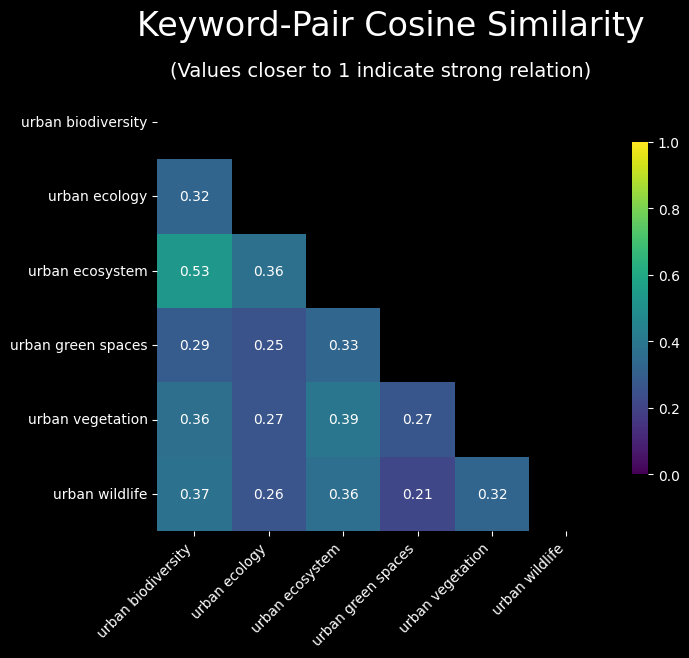

In [12]:
df_exploded_occurrence = df_keyword_occurrence.explode("keywords")
df_exploded_occurrence["keywords"] = df_exploded_occurrence["keywords"].str.strip()
keyword_counts = df_exploded_occurrence["keywords"].value_counts()

df_single_keyword = df_keyword_occurrence[df_keyword_occurrence["keywords"].apply(len) == 1]
solo_counts = df_single_keyword.explode("keywords")["keywords"].value_counts()

df_keyword_stats = pd.DataFrame({
    "total": keyword_counts,
    "solo": solo_counts
}).fillna(0)

df_keyword_stats["solo_ratio"] = (df_keyword_stats["solo"] / df_keyword_stats["total"]).round(2)

pair_counts = Counter()

for keyword_list in df_keyword_occurrence["keywords"]:
    unique_keywords = sorted([kw.strip() for kw in keyword_list])
    for kw1, kw2 in combinations(unique_keywords, 2):
        pair_counts[(kw1, kw2)] += 1
        
all_keywords = sorted(keyword_counts.index)

cooc_matrix = pd.DataFrame(np.zeros((len(all_keywords), len(all_keywords))),
                           index=all_keywords, columns=all_keywords)

for (kw1, kw2), count in pair_counts.items():
    cooc_matrix.at[kw2, kw1] = count / math.sqrt(keyword_counts[kw1] * keyword_counts[kw2])
num_keywords = len(cooc_matrix)
cell_size = 1.2

plt.figure(figsize=(num_keywords * cell_size, num_keywords * cell_size))

mask = np.triu(np.ones_like(cooc_matrix, dtype=bool))

sns.heatmap(cooc_matrix, 
            mask=mask,
            cmap="viridis",
            annot=True,
            fmt=".2f",
            square=True, 
            cbar_kws={"shrink": 0.6},
            vmin=0,
            vmax=1)

plt.suptitle("Keyword-Pair Cosine Similarity", fontsize=24, x=0.45, y=0.91)
plt.title("(Values closer to 1 indicate strong relation)", fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.show()

We can see the keywords have relatively low similarity, meaning they do occur together occasionally, but mostly cover their own fields. Whiles this might be bad news in other scenarios, I believe it actually is a positive outlook in this case, as it shows my choice of keywords cast a wider net to obtain a larger amount of papers related to the research of urban environments.

Next I looked into the data over time, seeing how the relatioships changed over time. Since initial data was sparse, which can cause some issues with the similarity calculation, I went with 5-year intervals. That is, i grouped all of the data every 5 years before I performed the relationship analysis.

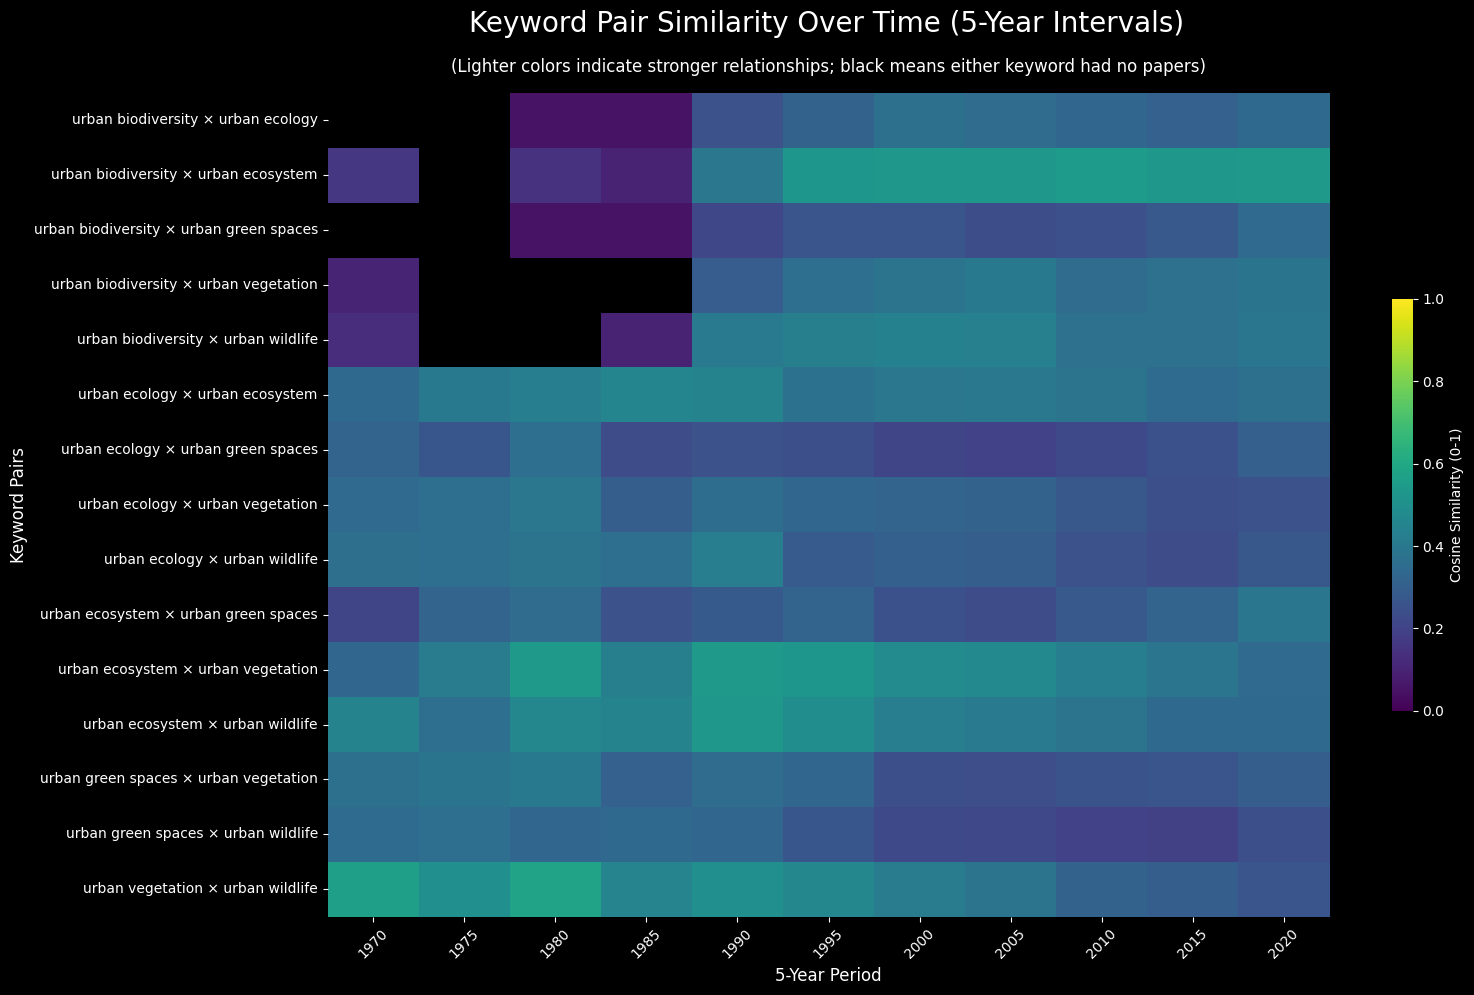

In [13]:
df_keyword_pivot = df_keywords.pivot(index='search_keyword', columns='year', values='paper_count')
df_keyword_pivot.fillna(0, inplace=True)

year_pair_counts = {}

for _, row in df_keyword_occurrence.iterrows():
    year = row['year']
    year_bin = (year // 5) * 5
    keyword_list = row['keywords']
    
    unique_keywords = sorted([kw.strip() for kw in keyword_list])
    for kw1, kw2 in combinations(unique_keywords, 2):
        pair_key = f"{kw1} × {kw2}"
        
        if year_bin not in year_pair_counts:
            year_pair_counts[year_bin] = {}
        if pair_key not in year_pair_counts[year_bin]:
            year_pair_counts[year_bin][pair_key] = 0
        year_pair_counts[year_bin][pair_key] += 1

pair_time_data = []
for year_bin, pairs_dict in year_pair_counts.items():
    for pair, count in pairs_dict.items():
        pair_time_data.append({
            'year_bin': year_bin,
            'keyword_pair': pair,
            'cooccurrence_count': count
        })

df_pair_time = pd.DataFrame(pair_time_data)
df_pair_pivot = df_pair_time.pivot(index='keyword_pair', columns='year_bin', values='cooccurrence_count')
df_pair_pivot.fillna(0, inplace=True)

df_keywords_binned = df_keywords.copy()
df_keywords_binned['year_bin'] = (df_keywords_binned['year'] // 5) * 5
df_keyword_binned_counts = df_keywords_binned.groupby(['search_keyword', 'year_bin'])['paper_count'].sum().reset_index()
df_keyword_year_counts = df_keyword_binned_counts.pivot(index='search_keyword', columns='year_bin', values='paper_count')
df_keyword_year_counts.fillna(0, inplace=True)

df_pair_similarity = df_pair_pivot.copy()

for pair_name in df_pair_similarity.index:
    kw1, kw2 = pair_name.split(' × ')
    
    for year_bin in df_pair_similarity.columns:
        if year_bin in df_keyword_year_counts.columns:
            kw1_count = df_keyword_year_counts.loc[kw1, year_bin] if kw1 in df_keyword_year_counts.index else 0
            kw2_count = df_keyword_year_counts.loc[kw2, year_bin] if kw2 in df_keyword_year_counts.index else 0
            
            if kw1_count > 0 and kw2_count > 0:
                df_pair_similarity.loc[pair_name, year_bin] = df_pair_pivot.loc[pair_name, year_bin] / math.sqrt(kw1_count * kw2_count)
            else:
                df_pair_similarity.loc[pair_name, year_bin] = 0
                

plt.figure(figsize=(16, 10))

year_totals = df_pair_similarity.sum(axis=0)
active_years = year_totals[year_totals > 0].index
df_similarity_active = df_pair_similarity[active_years]

mask_zeros = df_similarity_active == 0

sns.heatmap(df_similarity_active, 
            mask=mask_zeros,
            cmap="viridis",
            cbar_kws={"shrink": 0.5, "label": "Cosine Similarity (0-1)"},
            yticklabels=True,
            xticklabels=True,
            vmin=0,
            vmax=1)

plt.suptitle("Keyword Pair Similarity Over Time (5-Year Intervals)", fontsize=20, y=0.99, x=0.52)
plt.title("(Lighter colors indicate stronger relationships; black means either keyword had no papers)", fontsize=12, pad=15)
plt.xlabel("5-Year Period", fontsize=12)
plt.ylabel("Keyword Pairs", fontsize=12)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

A similar picture to our matrix above showed up hear with the data over time. Relatioships didn't change much over time, with the one interesting case being the urban biodiversity X urban ecosystem case, which could mean a trend of shared research over time, though the value still isn't high enough to draw any conslusions.

# Geographical Data Analysis

In this next step, I'll obtain geographical data to draw a choropleth map with the publication data. We'll first need to perform some API calls again to fill in the gaps of our country ISO data, since OpenAlex doesn't have a lot of institution data indexed.


We'll start by doing more OpenAlex calls to fill a second table in our papers.db, gathering every first author, as we ll as their affiliation (institution) and its Research Organization Registry (ROR).
We'll use this ID to make some more API call to ROR as they'll help us obtain the missing country data.

In [14]:
# === Author Data Retrieval Helper Functions ===

def get_unique_author_ids():
    """Retrieve unique first author IDs from papers database"""
    with sqlite3.connect(PAPERS_DB_PATH) as conn:
        df_authors = pd.read_sql_query("""
        SELECT DISTINCT firstAuthorId 
        FROM papers 
        WHERE firstAuthorId IS NOT NULL 
        AND firstAuthorId != ''
        ORDER BY firstAuthorId
        """, conn)
    return df_authors['firstAuthorId'].tolist()

def save_author_to_db(author_data):
    """Save author information to database"""
    conn = sqlite3.connect(PAPERS_DB_PATH)
    c = conn.cursor()
    
    # Create authors table if it doesn't exist
    c.execute(f'CREATE TABLE IF NOT EXISTS authors ({authors_schema})')
    
    author_id = author_data.get('id', '').replace('https://openalex.org/', '')
    name = author_data.get('display_name')
    
    # Get last known institution information
    institution_name = None
    institution_ror = None
    
    # Try last_known_institutions (plural) - this is the correct OpenAlex API field
    last_known_institutions = author_data.get('last_known_institutions', [])
    if last_known_institutions and len(last_known_institutions) > 0:
        institution = last_known_institutions[0]  # Get the most recent institution
        institution_name = institution.get('display_name')
        institution_ror = institution.get('ror')
        if institution_ror:
            institution_ror = institution_ror.replace('https://ror.org/', '')
    
    # Fallback: try old singular field in case API varies
    if not institution_name:
        last_known_institution = author_data.get('last_known_institution')
        if last_known_institution:
            institution_name = last_known_institution.get('display_name')
            institution_ror = last_known_institution.get('ror')
            if institution_ror:
                institution_ror = institution_ror.replace('https://ror.org/', '')
    
    try:
        # Check if author already exists
        c.execute('SELECT authorId FROM authors WHERE authorId = ?', (author_id,))
        existing = c.fetchone()
        
        if existing:
            # Update existing record
            c.execute("""
                UPDATE authors 
                SET name = ?, last_known_institution_name = ?, last_known_institution_ror = ?
                WHERE authorId = ?
            """, (name, institution_name, institution_ror, author_id))
        else:
            # Insert new record
            c.execute("""
                INSERT INTO authors 
                (authorId, name, last_known_institution_name, last_known_institution_ror, country_code, country_name)
                VALUES (?, ?, ?, ?, ?, ?)
            """, (author_id, name, institution_name, institution_ror, None, None))
        
        conn.commit()
        return True
        
    except sqlite3.Error as e:
        print(f'❌ DB error for author {author_id}: {e}')
        return False
    finally:
        conn.close()


In [ ]:
# === Execute Author Data Retrieval Loop (Enhanced) ===

print('🔍 PHASE 2: AUTHOR DATA RETRIEVAL (ENHANCED)')
print('=' * 60)

# Get unique author IDs
unique_author_ids = get_unique_author_ids()
print(f'📊 Found {len(unique_author_ids)} unique first authors')

# Check existing authors
init_table(PAPERS_DB_PATH, 'authors', authors_schema)

with sqlite3.connect(PAPERS_DB_PATH) as conn:
    try:
        existing_authors = pd.read_sql_query('SELECT COUNT(*) as count FROM authors', conn)
        existing_count = existing_authors['count'].iloc[0]
        print(f'📚 Existing authors in database: {existing_count}')
        
        # Check institution coverage
        institution_stats = pd.read_sql_query("""
        SELECT 
            COUNT(*) as total_authors,
            COUNT(last_known_institution_name) as authors_with_institutions,
            COUNT(last_known_institution_ror) as authors_with_ror
        FROM authors
        """, conn).iloc[0]
        
        print(f'🏢 Current institution coverage:')
        print(f'   Authors with institution names: {institution_stats["authors_with_institutions"]:,} ({institution_stats["authors_with_institutions"]/institution_stats["total_authors"]*100:.1f}%)')
        print(f'   Authors with ROR IDs: {institution_stats["authors_with_ror"]:,} ({institution_stats["authors_with_ror"]/institution_stats["total_authors"]*100:.1f}%)')
        
    except:
        existing_count = 0
        print('📚 No existing authors table found - created new one')

# Determine which authors to fetch - include those missing institution data
if existing_count > 0:
    with sqlite3.connect(PAPERS_DB_PATH) as conn:
        # Get authors that either don't exist OR are missing institution data
        authors_needing_fetch = pd.read_sql_query("""
        SELECT DISTINCT p.firstAuthorId
        FROM papers p
        WHERE p.firstAuthorId IS NOT NULL 
        AND p.firstAuthorId != ''
        AND (
            -- Author doesn't exist in authors table
            NOT EXISTS (SELECT 1 FROM authors a WHERE a.authorId = p.firstAuthorId)
            OR
            -- Author exists but missing institution data
            EXISTS (
                SELECT 1 FROM authors a 
                WHERE a.authorId = p.firstAuthorId 
                AND (a.last_known_institution_name IS NULL OR a.last_known_institution_name = '')
            )
        )
        ORDER BY p.firstAuthorId
        """, conn)
        
        authors_to_fetch = authors_needing_fetch['firstAuthorId'].tolist()
        
        # Separate new vs re-fetch for reporting
        existing_ids = pd.read_sql_query('SELECT authorId FROM authors', conn)['authorId'].tolist()
        new_author_ids = [aid for aid in authors_to_fetch if aid not in existing_ids]
        refetch_author_ids = [aid for aid in authors_to_fetch if aid in existing_ids]
        
        print(f'🆕 New authors to fetch: {len(new_author_ids)}')
        print(f'🔄 Existing authors to re-fetch (missing institutions): {len(refetch_author_ids)}')
        print(f'📝 Total authors to process: {len(authors_to_fetch)}')
        
else:
    authors_to_fetch = unique_author_ids
    new_author_ids = authors_to_fetch
    refetch_author_ids = []
    print(f'⏳ Fetching all {len(unique_author_ids)} authors')

if len(authors_to_fetch) == 0:
    print('✅ All authors already in database with complete institution data!')
else:
    # === Enhanced Author Retrieval Loop ===
    total_authors = len(authors_to_fetch)
    processed = 0
    successful = 0
    updated_institutions = 0
    batch_size = 50  # OpenAlex max per request
    
    print(f'\n🚀 Starting enhanced author retrieval: {total_authors} authors')
    print(f'   - {len(new_author_ids)} new authors')
    print(f'   - {len(refetch_author_ids)} re-fetch for missing institutions')
    
    # Process in batches
    for i in range(0, total_authors, batch_size):
        batch = authors_to_fetch[i:i + batch_size]
        batch_urls = [f'https://openalex.org/{author_id}' for author_id in batch]
        
        params = {
            'filter': f'openalex_id:{"|".join(batch_urls)}',
            'per_page': len(batch),
            'mailto': 'andre.borja.miranda@gmail.com'
        }
        
        batch_num = i//batch_size + 1
        total_batches = (total_authors + batch_size - 1)//batch_size
        
        for attempt in range(2):
            try:
                print(f'📡 Batch {batch_num}/{total_batches}: Fetching authors {i+1}-{min(i+batch_size, total_authors)}...')
                
                sys.stdout.flush()
                response = requests.get(AUTHOR_URL, params=params, timeout=30)
                response.raise_for_status()
                sys.stdout.flush()
                
                data = response.json()
                break
                
            except requests.exceptions.RequestException as e:
                print(f'❌ Request error on attempt {attempt+1}: {e}')
                if attempt == 0:
                    print(f'⏳ Retrying after {RETRY_DELAY} seconds...')
                    time.sleep(RETRY_DELAY)
                else:
                    print('⚠️ Skipping this batch due to repeated failure.')
                    data = None
        
        if data is None:
            continue
            
        if 'error' in data:
            print(f'❌ API Error: {data.get("message", "Unknown error")}')
            continue
            
        authors = data.get('results', [])
        
        # Save each author to database and track institution updates
        batch_successful = 0
        batch_institution_updates = 0
        
        for author in authors:
            author_id = author.get('id', '').replace('https://openalex.org/', '')
            was_refetch = author_id in refetch_author_ids
            
            # Check if this author had institution data before (for re-fetches)
            had_institution_before = False
            if was_refetch:
                with sqlite3.connect(PAPERS_DB_PATH) as conn:
                    existing_institution = pd.read_sql_query("""
                    SELECT last_known_institution_name 
                    FROM authors 
                    WHERE authorId = ?
                    """, conn, params=(author_id,))
                    
                    if not existing_institution.empty:
                        had_institution_before = bool(existing_institution.iloc[0]['last_known_institution_name'])
            
            if save_author_to_db(author):
                batch_successful += 1
                
                # Track if we successfully added institution data for a re-fetch
                if was_refetch and not had_institution_before:
                    last_known_institutions = author.get('last_known_institutions', [])
                    if last_known_institutions and len(last_known_institutions) > 0:
                        institution = last_known_institutions[0]
                        if institution.get('display_name'):
                            batch_institution_updates += 1
        
        successful += batch_successful
        updated_institutions += batch_institution_updates
        processed += len(batch)
        
        print(f'✅ Batch results: {batch_successful}/{len(batch)} saved, {batch_institution_updates} new institution data')
        
        # Rate limiting
        if i + batch_size < total_authors:
            time.sleep(DELAY)
    
    print(f'\n🎉 Enhanced author retrieval completed!')
    print(f'📊 Results: {successful}/{processed} authors successfully processed')
    print(f'🏢 Institution updates: {updated_institutions} authors gained institution data')

# Enhanced Summary
print('\n' + '='*60)
print('ENHANCED AUTHOR DATA SUMMARY')
print('='*60)

with sqlite3.connect(PAPERS_DB_PATH) as conn:
    summary_stats = pd.read_sql_query("""
    SELECT 
        COUNT(*) as total_authors,
        COUNT(last_known_institution_name) as authors_with_institutions,
        COUNT(last_known_institution_ror) as authors_with_ror,
        COUNT(DISTINCT last_known_institution_ror) as unique_ror_institutions,
        
        -- Coverage improvement metrics
        ROUND(COUNT(last_known_institution_name) * 100.0 / COUNT(*), 1) as institution_coverage_pct,
        ROUND(COUNT(last_known_institution_ror) * 100.0 / COUNT(*), 1) as ror_coverage_pct
    FROM authors
    """, conn)
    
    # Also check which authors still have no institution data
    missing_institutions = pd.read_sql_query("""
    SELECT COUNT(*) as authors_missing_institutions
    FROM authors
    WHERE last_known_institution_name IS NULL OR last_known_institution_name = ''
    """, conn).iloc[0]['authors_missing_institutions']
    
    stats = summary_stats.iloc[0]
    print(f"✅ Total authors: {stats['total_authors']:,}")
    print(f"✅ Authors with institutions: {stats['authors_with_institutions']:,} ({stats['institution_coverage_pct']}%)")
    print(f"✅ Authors with ROR IDs: {stats['authors_with_ror']:,} ({stats['ror_coverage_pct']}%)")
    print(f"✅ Unique institutions (ROR): {stats['unique_ror_institutions']:,}")

🔍 PHASE 2: AUTHOR DATA RETRIEVAL (ENHANCED)
📊 Found 45821 unique first authors
📚 Existing authors in database: 45805
🏢 Current institution coverage:
   Authors with institution names: 41,455 (90.5%)
   Authors with ROR IDs: 41,453 (90.5%)
🆕 New authors to fetch: 16
🔄 Existing authors to re-fetch (missing institutions): 4350
📝 Total authors to process: 4366

🚀 Starting enhanced author retrieval: 4366 authors
   - 16 new authors
   - 4350 re-fetch for missing institutions
📡 Batch 1/88: Fetching authors 1-50...
🆕 New authors to fetch: 16
🔄 Existing authors to re-fetch (missing institutions): 4350
📝 Total authors to process: 4366

🚀 Starting enhanced author retrieval: 4366 authors
   - 16 new authors
   - 4350 re-fetch for missing institutions
📡 Batch 1/88: Fetching authors 1-50...
✅ Batch results: 50/50 saved, 3 new institution data
✅ Batch results: 50/50 saved, 3 new institution data
📡 Batch 2/88: Fetching authors 51-100...
📡 Batch 2/88: Fetching authors 51-100...
✅ Batch results: 50/50 

In [17]:
# === PHASE 3: ROR GEOGRAPHIC ENHANCEMENT (RESUMABLE) ===

print('🌍 PHASE 3: ROR GEOGRAPHIC ENHANCEMENT (RESUMABLE)')
print('=' * 60)

ROR_BASE_URL = 'https://api.ror.org/v2/organizations'
ROR_DELAY = 0.1  # More conservative delay (600 requests/min)
MAX_RETRIES = 3

def get_ror_country_data_robust(ror_ids_batch, max_retries=MAX_RETRIES):
    """Enhanced ROR data fetching with session reuse and better error handling"""
    ror_data = {}
    headers = {
        'User-Agent': f'UrbanEcologyResearch/1.0 (https://github.com/Borjabor/UrbanEcologyResearchTrend; {ROR_CLIENT_ID})',
        'Accept': 'application/json',
        'Connection': 'keep-alive'
    }
    
    # Use session for connection reuse (major performance improvement)
    session = requests.Session()
    session.headers.update(headers)
    
    successful_requests = 0
    failed_requests = 0
    
    for ror_id in ror_ids_batch:
        success = False
        
        for attempt in range(max_retries):
            try:
                start_request = time.time()
                response = session.get(
                    f"{ROR_BASE_URL}/{ror_id}", 
                    timeout=15,  # Increased timeout
                    stream=False
                )
                
                if response.status_code == 200:
                    data = response.json()
                    locations = data.get('locations', [])
                    
                    if locations:
                        geonames = locations[0].get('geonames_details', {})
                        country_code = geonames.get('country_code')
                        country_name = geonames.get('country_name')
                        
                        ror_data[ror_id] = {
                            'country_code': country_code, 
                            'country_name': country_name
                        } if country_code else None
                    else:
                        ror_data[ror_id] = None
                    
                    successful_requests += 1
                    success = True
                    break
                    
                elif response.status_code == 429:  # Rate limited
                    wait_time = 5 + (attempt * 2)  # Exponential backoff
                    print(f"⏳ Rate limited on {ror_id}, waiting {wait_time}s...")
                    time.sleep(wait_time)
                    
                elif response.status_code == 404:
                    print(f"❌ ROR ID not found: {ror_id}")
                    ror_data[ror_id] = None
                    success = True
                    break
                    
                else:
                    print(f"⚠️ HTTP {response.status_code} for {ror_id} (attempt {attempt+1})")
                    if attempt < max_retries - 1:
                        time.sleep(2)
                    
            except requests.exceptions.Timeout:
                print(f"⏱️ Timeout for {ror_id} (attempt {attempt+1})")
                if attempt < max_retries - 1:
                    time.sleep(3)
                    
            except requests.exceptions.ConnectionError:
                print(f"🔌 Connection error for {ror_id} (attempt {attempt+1})")
                if attempt < max_retries - 1:
                    time.sleep(5)  # Longer wait for connection issues
                    
            except requests.exceptions.RequestException as e:
                print(f"❌ Request error for {ror_id} (attempt {attempt+1}): {e}")
                if attempt < max_retries - 1:
                    time.sleep(2)
        
        if not success:
            print(f"🚫 Failed to fetch {ror_id} after {max_retries} attempts")
            ror_data[ror_id] = None
            failed_requests += 1
        
        # Conservative rate limiting
        time.sleep(ROR_DELAY)
    
    session.close()
    return ror_data, successful_requests, failed_requests

# Setup: Add country columns to authors table if needed
with sqlite3.connect(PAPERS_DB_PATH) as conn:
    c = conn.cursor()
    c.execute("PRAGMA table_info(authors)")
    existing_columns = {col[1] for col in c.fetchall()}
    
    for col in ['country_code', 'country_name']:
        if col not in existing_columns:
            c.execute(f"ALTER TABLE authors ADD COLUMN {col} TEXT")
            print(f"✅ Added {col} column to authors table")
    
    conn.commit()

# Check current progress and get remaining ROR IDs
with sqlite3.connect(PAPERS_DB_PATH) as conn:
    # Check overall progress first
    progress_stats = pd.read_sql_query("""
    SELECT 
        COUNT(*) as total_authors_with_ror,
        COUNT(country_code) as authors_with_country,
        COUNT(*) - COUNT(country_code) as authors_missing_country
    FROM authors 
    WHERE last_known_institution_ror IS NOT NULL
    """, conn).iloc[0]
    
    print(f"📈 CURRENT PROGRESS:")
    print(f"   Authors with ROR IDs: {progress_stats['total_authors_with_ror']:,}")
    print(f"   Already have country data: {progress_stats['authors_with_country']:,}")
    print(f"   Still need country data: {progress_stats['authors_missing_country']:,}")
    
    if progress_stats['authors_with_country'] > 0:
        completion_pct = (progress_stats['authors_with_country'] / progress_stats['total_authors_with_ror']) * 100
        print(f"   Progress: {completion_pct:.1f}% complete")
    
    # Get remaining ROR IDs to process
    ror_stats = pd.read_sql_query("""
    SELECT last_known_institution_ror, COUNT(DISTINCT authorId) as author_count
    FROM authors 
    WHERE last_known_institution_ror IS NOT NULL 
    AND (country_code IS NULL OR country_code = '')
    GROUP BY last_known_institution_ror
    ORDER BY author_count DESC
    """, conn)

if len(ror_stats) == 0:
    print("\n✅ All authors with ROR IDs already have country data!")
else:
    ror_ids_to_fetch = ror_stats['last_known_institution_ror'].tolist()
    total_authors_to_enhance = ror_stats['author_count'].sum()
    
    print(f"\n🎯 RESUMING ENHANCEMENT:")
    print(f"   Remaining ROR IDs: {len(ror_ids_to_fetch)}")
    print(f"   Authors to be enhanced: {total_authors_to_enhance:,}")
    
    # Realistic time estimation based on:
    # - 0.1s delay per request
    # - ~2-3s average per request (including network overhead, retries)
    estimated_seconds_per_request = 2.5
    estimated_total_minutes = (len(ror_ids_to_fetch) * estimated_seconds_per_request) / 60
    print(f"   Realistic time estimate: ~{estimated_total_minutes:.1f} minutes")
    
    # Use smaller batches for better resumability
    batch_size = 25  # Smaller batches = better progress tracking
    successful_total = 0
    failed_total = 0
    
    start_time = time.time()
    
    for i in range(0, len(ror_ids_to_fetch), batch_size):
        batch = ror_ids_to_fetch[i:i + batch_size]
        batch_num = i // batch_size + 1
        total_batches = (len(ror_ids_to_fetch) + batch_size - 1) // batch_size
        
        print(f"\n📡 Batch {batch_num}/{total_batches}: Processing {len(batch)} ROR IDs...")
        batch_start_time = time.time()
        
        # Fetch data for this batch
        ror_results, batch_successful, batch_failed = get_ror_country_data_robust(batch)
        
        # Update database immediately after each batch (for resumability)
        with sqlite3.connect(PAPERS_DB_PATH) as conn:
            c = conn.cursor()
            batch_updates = 0
            
            for ror_id, data in ror_results.items():
                if data and data.get('country_code'):
                    try:
                        c.execute("""
                        UPDATE authors 
                        SET country_code = ?, country_name = ? 
                        WHERE last_known_institution_ror = ?
                        """, (data['country_code'], data['country_name'], ror_id))
                        batch_updates += 1
                    except sqlite3.Error as e:
                        print(f"❌ DB error for ROR {ror_id}: {e}")
            
            conn.commit()
            
        successful_total += batch_updates
        failed_total += batch_failed
        
        # Performance tracking and ETA calculation
        batch_duration = time.time() - batch_start_time
        avg_time_per_request = batch_duration / len(batch)
        
        print(f"✅ Batch results: {batch_successful} successful, {batch_failed} failed, {batch_updates} DB updates")
        print(f"⏱️ Batch took {batch_duration:.1f}s ({avg_time_per_request:.2f}s per request)")
        
        # Calculate ETA based on actual performance
        if batch_num >= 2:  # Wait for at least 2 batches for stable estimate
            elapsed_time = time.time() - start_time
            avg_time_per_batch = elapsed_time / batch_num
            remaining_batches = total_batches - batch_num
            eta_minutes = (remaining_batches * avg_time_per_batch) / 60
            
            print(f"📊 Overall progress: {batch_num}/{total_batches} batches ({(batch_num/total_batches)*100:.1f}%)")
            print(f"⏰ ETA: {eta_minutes:.1f} minutes remaining")
    
    total_duration = time.time() - start_time
    print(f"\n🎉 ROR enhancement completed in {total_duration/60:.1f} minutes!")
    print(f"📊 Final results: {successful_total} successful updates, {failed_total} failed requests")

# Update papers table using enhanced author country data (single SQL operation)
print(f"\n🔄 Updating papers with author-derived country data...")

with sqlite3.connect(PAPERS_DB_PATH) as conn:
    result = conn.execute("""
    UPDATE papers 
    SET firstAuthorCountryIso = (
        SELECT a.country_code 
        FROM authors a 
        WHERE a.authorId = papers.firstAuthorId AND a.country_code IS NOT NULL
    )
    WHERE firstAuthorCountryIso IS NULL 
    AND EXISTS (
        SELECT 1 FROM authors a 
        WHERE a.authorId = papers.firstAuthorId AND a.country_code IS NOT NULL
    )
    """)
    
    updated_count = result.rowcount
    conn.commit()
    print(f"✅ Updated {updated_count} papers with author-derived country data")

# Final summary statistics
print(f"\n{'='*60}\nGEOGRAPHIC ENHANCEMENT SUMMARY\n{'='*60}")

with sqlite3.connect(PAPERS_DB_PATH) as conn:
    stats = pd.read_sql_query("""
    SELECT 
        -- Papers
        COUNT(*) as total_papers,
        COUNT(firstAuthorCountryIso) as papers_with_country,
        ROUND(COUNT(firstAuthorCountryIso) * 100.0 / COUNT(*), 1) as papers_coverage_pct,
        
        -- Authors  
        (SELECT COUNT(*) FROM authors) as total_authors,
        (SELECT COUNT(country_code) FROM authors) as authors_with_country,
        (SELECT COUNT(DISTINCT country_code) FROM authors WHERE country_code IS NOT NULL) as unique_countries
    FROM papers
    """, conn).iloc[0]

print(f"📄 Papers: {stats['total_papers']:,} total, {stats['papers_with_country']:,} with country ({stats['papers_coverage_pct']}%)")
print(f"👥 Authors: {stats['total_authors']:,} total, {stats['authors_with_country']:,} with country data")
print(f"🌏 Unique countries identified: {stats['unique_countries']:,}")
print("\n🎯 Geographic enhancement complete! Ready for visualization.")

🌍 PHASE 3: ROR GEOGRAPHIC ENHANCEMENT (RESUMABLE)
📈 CURRENT PROGRESS:
   Authors with ROR IDs: 41,457
   Already have country data: 41,453
   Still need country data: 4
   Progress: 100.0% complete

🎯 RESUMING ENHANCEMENT:
   Remaining ROR IDs: 4
   Authors to be enhanced: 4
   Realistic time estimate: ~0.2 minutes

📡 Batch 1/1: Processing 4 ROR IDs...
✅ Batch results: 4 successful, 0 failed, 4 DB updates
⏱️ Batch took 1.6s (0.41s per request)

🎉 ROR enhancement completed in 0.0 minutes!
📊 Final results: 4 successful updates, 0 failed requests

🔄 Updating papers with author-derived country data...
✅ Updated 2 papers with author-derived country data

GEOGRAPHIC ENHANCEMENT SUMMARY
📄 Papers: 66,047.0 total, 52,239.0 with country (79.1%)
👥 Authors: 45,805.0 total, 41,457.0 with country data
🌏 Unique countries identified: 191.0

🎯 Geographic enhancement complete! Ready for visualization.
✅ Batch results: 4 successful, 0 failed, 4 DB updates
⏱️ Batch took 1.6s (0.41s per request)

🎉 ROR enh

In [18]:
# === Country Code Conversion Functions ===

def convert_alpha2_to_alpha3(alpha2_code):
    """Convert ISO 3166-1 alpha-2 country code to alpha-3"""
    try:
        country = pycountry.countries.get(alpha_2=alpha2_code)
        return country.alpha_3 if country else None
    except:
        return None

def get_country_name(alpha2_code):
    """Get country name from ISO 3166-1 alpha-2 country code"""
    try:
        country = pycountry.countries.get(alpha_2=alpha2_code)
        return country.name if country else None
    except:
        return None

In [ ]:
with sqlite3.connect(PAPERS_DB_PATH) as conn:
    df_countries_raw = pd.read_sql_query("""
    SELECT 
        firstAuthorCountryIso as alpha2_code,
        COUNT(*) as paper_count
    FROM papers
    WHERE firstAuthorCountryIso IS NOT NULL
    GROUP BY firstAuthorCountryIso
    ORDER BY paper_count DESC
    """, conn)

df_countries = df_countries_raw.copy()
df_countries['alpha3_code'] = df_countries['alpha2_code'].apply(convert_alpha2_to_alpha3)
df_countries['country_name'] = df_countries['alpha2_code'].apply(get_country_name)

unmapped = df_countries[df_countries['alpha3_code'].isna()]
if not unmapped.empty:
    print('⚠️ Found unmapped country codes:')
    for _, row in unmapped.iterrows():
        print(f'{row["alpha2_code"]}: {row["paper_count"]} papers')

df_countries.dropna(subset=['alpha3_code', 'country_name'], inplace=True)

df_countries.head(20)

⚠️ Found unmapped country codes:
XK: 3 papers


,alpha2_code,paper_count,alpha3_code,country_name
0,US,13481,USA,United States
1,GB,6124,GBR,United Kingdom
2,AU,2460,AUS,Australia
3,DE,2455,DEU,Germany
4,IT,2182,ITA,Italy
5,IN,1792,IND,India
6,CA,1604,CAN,Canada
7,CN,1538,CHN,China
8,FR,1523,FRA,France
9,BR,1515,BRA,Brazil


In [22]:
fig = px.choropleth(
    df_countries, 
    locations='alpha3_code',
    color='paper_count',
    hover_name='country_name',
    hover_data={
        'alpha3_code': True, 
        'paper_count': ':,',
        'country_name': False
    },
    color_continuous_scale='Viridis',
    title='Global Distribution of Urban Ecology Research Papers by First Author Country',
    labels={
        'paper_count': 'Number of Papers',
        'alpha3_code': 'ISO Alpha-3'
    }
)

fig.update_traces(
    marker_line_color='white',
    marker_line_width=0.5
)

fig.update_layout(
    template='plotly_dark',
    width=1200,
    height=700,
    title_font_size=16,
    geo=dict(
        showframe=False,
        showcoastlines=True,
        coastlinecolor='white',
        coastlinewidth=0.5,
        showland=True,
        landcolor='rgb(70, 70, 70)',
        showocean=True,
        oceancolor='rgb(30, 30, 30)',
        projection_type='natural earth',
        bgcolor='rgba(0,0,0,0)',
    ),
    coloraxis_colorbar=dict(
        title_font_color='white',
        tickfont_color='white'
    )
)

fig.show()

print('=' * 80)

fig_treemap = px.treemap(
    df_countries.head(20),
    names='country_name',
    values='paper_count',
    parents=[''] * 20, 
    title='Top 20 Countries by Urban Ecology Research Output',
    labels={'paper_count': 'Number of Papers', 'country_name': 'Country'},
    color='paper_count',
    color_continuous_scale='Viridis',
    hover_data={
        'alpha2_code': True,
        'alpha3_code': True,
        'paper_count': ':,',
    }
)

# Threshold calculation to avoid unreadable text
max_val = df_countries.head(20)['paper_count'].max()
min_val = df_countries.head(20)['paper_count'].min()
threshold = min_val + (max_val - min_val) * 0.7

text_colors = ['black' if val > threshold else 'white' for val in df_countries.head(20)['paper_count']]

fig_treemap.update_traces(
    textinfo='label+value',
    textfont_size=12,
    textfont_color=text_colors,
    hovertemplate='<b>%{label}</b><br>' +
                  'Papers: %{value:,}<br>' +
                  'ISO-3: %{customdata[1]}<br>' +
                  '<extra></extra>'
)

fig_treemap.update_layout(
    height=700,
    width=1200,
    template='plotly_dark',
    font=dict(size=14),
    title_font_size=18,
    margin=dict(t=50, l=25, r=25, b=25)
)

fig_treemap.show()